In [99]:
!git clone https://github.com/vklunna/bachelor-thesis-group32-new

fatal: destination path 'bachelor-thesis-group32-new' already exists and is not an empty directory.


In [100]:
!git clone https://github.com/cvonkrogh/Thesis

fatal: destination path 'Thesis' already exists and is not an empty directory.


In [101]:
!pip install rapidfuzz
!pip install statsmodels pandas patsy --quiet
!pip install yfinance pandas --quiet
!pip install yfinance pandas numpy --quiet
!pip install matplotlib


#disclosure matrix

In [102]:
# --- libraries ---------------------------------------------------------
import pandas as pd, re, glob, os, pathlib


ESRS_CODES = [
    # E1 Climate change
    "E1-1","E1-2","E1-3","E1-4","E1-5","E1-6","E1-7","E1-8","E1-9",
    # E2 Pollution
    "E2-1","E2-2","E2-3","E2-4","E2-5",
    # E3 Water & marine
    "E3-1","E3-2","E3-3","E3-4","E3-5",
    # E4 Biodiversity & ecosystems
    "E4-1","E4-2","E4-3","E4-4","E4-5","E4-6",
    # E5 Resource use & circular economy
    "E5-1","E5-2","E5-3","E5-4","E5-5","E5-6",
    # S1 Own workforce
    "S1-1","S1-2","S1-3","S1-4","S1-5","S1-6","S1-7","S1-8",
    "S1-9","S1-10","S1-11","S1-12","S1-13","S1-14","S1-15","S1-16","S1-17",
    # S2 Value-chain workers
    "S2-1","S2-2","S2-3","S2-4","S2-5",
    # S3 Affected communities
    "S3-1","S3-2","S3-3","S3-4","S3-5",
    # S4 Consumers & end-users
    "S4-1","S4-2","S4-3","S4-4","S4-5",
    # G1 Business conduct
    "G1-1","G1-2","G1-3","G1-4","G1-5","G1-6",
]


CODE_RE = re.compile(r"[A-Z]\d-\d+")

def codes_in_df(df: pd.DataFrame) -> set[str]:
    tokens = set()
    for col in df.columns:
        series = df[col].dropna().astype(str)
        for cell in series:
            tokens.update(CODE_RE.findall(cell))
    return tokens


ROOT = pathlib.Path("bachelor-thesis-group32-new/bachelor-thesis-group32-folder/2_output/filtered_tables")
rows = []

for company_dir in ROOT.iterdir():
    if not company_dir.is_dir():
        continue
    company = company_dir.name.lower()

    csvs = list(company_dir.rglob("*.csv"))
    seen = set()
    for fp in csvs:
        df = pd.read_csv(fp, header=None, dtype=str, low_memory=False)
        seen |= codes_in_df(df)

    row = {"company": company}
    row.update({code: int(code in seen) for code in ESRS_CODES})
    rows.append(row)


mat = (pd.DataFrame(rows)
          .set_index("company")
          .reindex(columns=ESRS_CODES))

mat.to_csv("esrs_disclosure_matrix.csv")
print("Saved → esrs_disclosure_matrix.csv with shape", mat.shape)

Saved → esrs_disclosure_matrix.csv with shape (90, 69)


#find ticker


In [103]:


import pandas as pd, requests, time, unicodedata, re
from rapidfuzz import fuzz


esrs = pd.read_csv("esrs_disclosure_matrix.csv")
raw_names = esrs["company"].unique().tolist()


def clean(txt):
    txt = unicodedata.normalize("NFKD", txt)
    txt = re.sub(r"[_\-]", " ", txt)
    txt = re.sub(r"\b(20\d{2}|annual|report|integrated|ar|urd|full|year|fy)\b",
                 "", txt, flags=re.I)
    txt = re.sub(r"\s{2,}", " ", txt)
    return txt.strip()


YH_URL = "https://query2.finance.yahoo.com/v1/finance/search"
headers = {"User-Agent": "Mozilla/5.0"}
rows = []

for nm in raw_names:
    q = clean(nm)
    try:
        r = requests.get(YH_URL,
                         params={"q": q, "quotesCount": 5, "newsCount": 0},
                         headers=headers, timeout=10)
        r.raise_for_status()
        quotes = r.json().get("quotes", [])
        hit = next((q for q in quotes if q.get("quoteType") == "EQUITY"), None)
    except Exception:
        hit = None

    if hit:
        longname = hit.get("longname") or hit.get("shortname") or ""
        score = fuzz.token_set_ratio(q.lower(), longname.lower()) / 100
        rows.append(dict(company=nm,
                         ticker=hit["symbol"],
                         exchange=hit.get("exchange", ""),
                         long_name=longname,
                         fy_end_month=None,          # fill in step 2 below
                         match_quality=f"{score:.2f}"))
    else:
        rows.append(dict(company=nm, ticker=None, exchange=None,
                         long_name=None, fy_end_month=None,
                         match_quality="no hit"))
    time.sleep(0.25)

mapping = pd.DataFrame(rows)
mapping.to_csv("auto_company_ticker_map.csv", index=False)
mapping.head()

,company,ticker,exchange,long_name,fy_end_month,match_quality
0,evonik_financial_and_sustainability_report_2024,None,None,None,None,no hit
1,annual-report-2024-equinor-compressed,None,None,None,None,no hit
2,2024 fbd holdings annual report 2024-compressed,None,None,None,None,no hit
3,abn_amro___integrated_annual_report_2024,ABN.AS,AMS,ABN AMRO Bank N.V.,None,1.00
4,f5937bce-c119-4d4d-91fd-9306c8d2c744,None,None,None,None,no hit


#look for fundamentals with tickers

In [104]:



import pandas as pd, numpy as np, yfinance as yf
from datetime import timedelta


MAP_FILE = pathlib.Path("Thesis/output/company_tickers_lookup.csv")
YEAR     = 2024
OUT_FILE = "fundamentals_2024.csv"


FY_MONTH_OVERRIDE = {}


def first_non_na(df, aliases, col):
    for key in aliases:
        if key in df.index and col in df.columns and pd.notna(df.at[key, col]):
            return float(df.at[key, col])
    return np.nan

def fundamentals_one(ticker, fy_month=12):
    tkr = yf.Ticker(ticker)
    bs, is_ = tkr.balance_sheet, tkr.financials
    if bs.empty or is_.empty:
        return None


    col = next((c for c in bs.columns
                if pd.to_datetime(c).year == YEAR
                and pd.to_datetime(c).month == fy_month), None)
    if col is None:
        return None

    A  = first_non_na(bs, ["Total Assets"], col)
    D  = first_non_na(bs, ["Total Debt", "Long Term Debt"], col)
    CA = first_non_na(bs, ["Total Current Assets", "Current Assets"], col)
    CL = first_non_na(bs, ["Total Current Liabilities", "Current Liabilities"], col)
    NI = first_non_na(is_, ["Net Income"], col)


    fy_end = pd.to_datetime(col)
    px = tkr.history(start=(fy_end - timedelta(days=7)),
                     end  =(fy_end + timedelta(days=7))).Close

    shares = tkr.info.get("sharesOutstanding", np.nan)
    mcap = px.iloc[-1] * shares if (not px.empty and shares) else np.nan

    return dict(
        ln_assets     = np.log(A) if A>0 else np.nan,
        roa           = NI/A      if A else np.nan,
        leverage      = D/A       if A and pd.notna(D) else np.nan,
        current_ratio = CA/CL     if CL else np.nan,
        ln_mcap       = np.log(mcap) if mcap>0 else np.nan,
    )


records = []
for company, ticker in pd.read_csv(MAP_FILE).values:
    if pd.isna(ticker) or ticker.strip() == "":
        continue                    # private / unknown → skip
    fy_m = FY_MONTH_OVERRIDE.get(company.lower(), 12)
    rec  = fundamentals_one(ticker, fy_m)
    if rec:
        rec["company"] = company
        records.append(rec)

fund = pd.DataFrame(records).set_index("company")
fund.to_csv(OUT_FILE)
print(f"✅ saved {OUT_FILE} with {len(fund)} companies")

✅ saved fundamentals_2024.csv with 80 companies


In [105]:
import pandas as pd, numpy as np, yfinance as yf
from datetime import timedelta

YEAR     = 2024
MAP_FILE = pathlib.Path("Thesis/output/company_tickers_lookup.csv")


def val(df, aliases, col):
    for a in aliases:
        if a in df.index and col in df.columns and pd.notna(df.at[a, col]):
            return float(df.at[a, col])
    return np.nan

def fundamentals_one(ticker, fy_month=12):
    tkr = yf.Ticker(ticker)
    bs, is_ = tkr.balance_sheet, tkr.financials
    if bs.empty or is_.empty:
        return None


    col = next((c for c in bs.columns
                if pd.to_datetime(c).year == YEAR
                and pd.to_datetime(c).month == fy_month), None)
    if col is None:
        return None


    TA = val(bs, ["Total Assets"], col)
    TD = val(bs, ["Total Debt", "Long Term Debt"], col)
    CA = val(bs, ["Total Current Assets", "Current Assets"], col)
    CL = val(bs, ["Total Current Liabilities", "Current Liabilities"], col)
    NI = val(is_, ["Net Income"], col)
    REV= val(is_, ["Total Revenue", "Operating Revenue"], col)


    fy_end = pd.to_datetime(col)
    px      = tkr.history(start=fy_end - timedelta(days=7),
                          end  =fy_end + timedelta(days=7)).Close
    shares  = tkr.info.get("sharesOutstanding", np.nan)
    mcap    = px.iloc[-1] * shares if (not px.empty and shares) else np.nan
    price   = px.iloc[-1] if not px.empty else np.nan


    return dict(
        total_assets      = TA,
        total_debt        = TD,
        current_assets    = CA,
        current_liabilities = CL,
        net_income        = NI,
        revenue           = REV,
        shares_out        = shares,
        close_price       = price,
        mkt_cap           = mcap,
        # ratios
        ln_assets     = np.log(TA) if TA>0 else np.nan,
        roa           = NI/TA      if TA else np.nan,
        leverage      = TD/TA      if TA and pd.notna(TD) else np.nan,
        current_ratio = CA/CL      if CL else np.nan,
        ln_mcap       = np.log(mcap) if mcap>0 else np.nan,
    )


records = []
for company, ticker in pd.read_csv(MAP_FILE).values:
    if pd.isna(ticker) or ticker.strip() == "":
        continue
    rec = fundamentals_one(ticker, fy_month=12)
    if rec:
        rec["company"] = company
        records.append(rec)

fund_df = pd.DataFrame(records).set_index("company")

print("Columns captured:", list(fund_df.columns))
display(fund_df.head())

Columns captured: ['total_assets', 'total_debt', 'current_assets', 'current_liabilities', 'net_income', 'revenue', 'shares_out', 'close_price', 'mkt_cap', 'ln_assets', 'roa', 'leverage', 'current_ratio', 'ln_mcap']


,total_assets,total_debt,current_assets,current_liabilities,net_income,revenue,shares_out,close_price,mkt_cap,ln_assets,roa,leverage,current_ratio,ln_mcap
company,,,,,,,,,,,,,,
verbund-integrated-annual-report-2024-englisch-final-1,1.871831e+10,2.298500e+09,2.498240e+09,1.773720e+09,1.875276e+09,8.244595e+09,170234000,68.712494,1.169720e+10,23.652768,0.100184,0.122794,1.408475,23.182616
amsterdam commodity,8.678540e+08,2.550730e+08,5.816810e+08,2.877280e+08,4.523400e+07,1.362823e+09,29617700,16.837416,4.986855e+08,20.581534,0.052122,0.293912,2.021635,20.027486
arkema,1.520900e+10,4.554000e+09,4.995000e+09,2.486000e+09,3.540000e+08,9.544000e+09,75439800,68.175400,5.143139e+09,23.445153,0.023276,0.299428,2.009252,22.360929
basf,8.041500e+10,2.399500e+10,3.123200e+10,1.703900e+10,1.298000e+09,6.526000e+10,892521984,40.122711,3.581040e+10,25.110467,0.016141,0.298390,1.832971,24.301504
20250407_viv_vivendi_urd_en,7.929000e+09,2.688000e+09,2.390000e+08,1.011000e+09,-6.004000e+09,2.970000e+08,992233984,2.609000,2.588738e+09,22.793793,-0.757220,0.339009,0.236400,21.674437


In [106]:
def show_cols(df, cols=None, n=10):
    """Display chosen columns (all if None) and first n rows."""
    display(df[cols] if cols else df.head(n))


show_cols(fund_df, ["total_assets", "net_income", "roa"])

,total_assets,net_income,roa
company,,,
verbund-integrated-annual-report-2024-englisch-final-1,1.871831e+10,1.875276e+09,0.100184
amsterdam commodity,8.678540e+08,4.523400e+07,0.052122
arkema,1.520900e+10,3.540000e+08,0.023276
basf,8.041500e+10,1.298000e+09,0.016141
20250407_viv_vivendi_urd_en,7.929000e+09,-6.004000e+09,-0.757220
...,...,...,...
aegon,3.273900e+11,6.880000e+08,0.002101
bank of ireland,1.618130e+11,1.531000e+09,0.009462
annual report 2024_zalando se_en_250503_s,7.983900e+09,2.511000e+08,0.031451


In [107]:
fund_df.to_csv("fundamentals_2024_all.csv")
print("✅ saved fundamentals_2024.csv with", fund_df.shape)

✅ saved fundamentals_2024.csv with (80, 14)


#add industry and country

In [108]:
import yfinance as yf, pandas as pd, time, random


tickers_path = pathlib.Path("Thesis/output/company_tickers_lookup.csv")   # company,ticker
tickers_df = pd.read_csv(tickers_path) # Read the CSV into a DataFrame
fund    = pd.read_csv("fundamentals_2024_all.csv")     # your ratios/values


def get_meta(ticker, max_tries=3):
    """
    Returns (industry, country) or ('Unknown','Unknown') on failure.
    Retries up to max_tries with exponential back-off.
    """
    for attempt in range(max_tries):
        try:
            info = yf.Ticker(str(ticker)).info
            industry = info.get("industry") or info.get("sector") or "Unknown"
            country  = info.get("country")  or "Unknown"
            return industry, country
        except Exception as e:
            if attempt == max_tries - 1:
                return "Unknown", "Unknown"
            # randomised sleep to avoid hammering the API
            time.sleep(1.5 * 2**attempt + random.random())


meta_rows = []
for comp, tkr in tickers_df.values: # Access values from the DataFrame
    if pd.isna(tkr) or str(tkr).strip() == "":
        meta_rows.append({"company": comp, "industry": "Unknown", "country": "Unknown"})
    else:
        ind, ctry = get_meta(tkr)
        meta_rows.append({"company": comp, "industry": ind, "country": ctry})

meta_df = pd.DataFrame(meta_rows)


fund_enriched = fund.merge(meta_df, on="company", how="left")

print("New columns:", list(fund_enriched.columns)[-3:])   # shows industry & country
display(fund_enriched.head())

ERROR:yfinance:HTTP Error 404: 


New columns: ['ln_mcap', 'industry', 'country']


,company,total_assets,total_debt,current_assets,current_liabilities,net_income,revenue,shares_out,close_price,mkt_cap,ln_assets,roa,leverage,current_ratio,ln_mcap,industry,country
0,verbund-integrated-annual-report-2024-englisch...,1.871831e+10,2.298500e+09,2.498240e+09,1.773720e+09,1.875276e+09,8.244595e+09,170234000,68.712494,1.169720e+10,23.652768,0.100184,0.122794,1.408475,23.182616,Utilities - Renewable,Austria
1,amsterdam commodity,8.678540e+08,2.550730e+08,5.816810e+08,2.877280e+08,4.523400e+07,1.362823e+09,29617700,16.837416,4.986855e+08,20.581534,0.052122,0.293912,2.021635,20.027486,Food Distribution,Netherlands
2,arkema,1.520900e+10,4.554000e+09,4.995000e+09,2.486000e+09,3.540000e+08,9.544000e+09,75439800,68.175400,5.143139e+09,23.445153,0.023276,0.299428,2.009252,22.360929,Specialty Chemicals,France
3,basf,8.041500e+10,2.399500e+10,3.123200e+10,1.703900e+10,1.298000e+09,6.526000e+10,892521984,40.122711,3.581040e+10,25.110467,0.016141,0.298390,1.832971,24.301504,Chemicals,Germany
4,20250407_viv_vivendi_urd_en,7.929000e+09,2.688000e+09,2.390000e+08,1.011000e+09,-6.004000e+09,2.970000e+08,992233984,2.609000,2.588738e+09,22.793793,-0.757220,0.339009,0.236400,21.674437,Entertainment,France


In [109]:
fund_enriched.to_csv("fundamentals_2024_with_meta.csv", index=False)
print("✅ saved fundamentals_2024_with_meta.csv")

✅ saved fundamentals_2024_with_meta.csv


#final data set

In [110]:
import pandas as pd


esrs = pd.read_csv("/content/Thesis/output/esrs_disclosure_matrix.csv")          # 69 ESRS flags
fund = pd.read_csv("/content/Thesis/output/fundamentals_2024_with_meta.csv")           # raw + ratio columns


print("ESRS companies:", esrs.company.nunique())
print("Fund companies:", fund.company.nunique())


merged = esrs.merge(fund, on="company", how="inner")

print(f"\n✅ merged rows: {len(merged)}  "
      f"({len(merged)/len(esrs):.0%} of ESRS sample have fundamentals)")
print("Columns in final set:", merged.shape[1])


display(merged.head())                                    # optional, shows first 5 rows
merged.to_csv("esrs_2024_with_fundamentals.csv", index=False)
print("\n📁 saved → esrs_2024_with_fundamentals.csv")

ESRS companies: 100
Fund companies: 80

✅ merged rows: 80  (80% of ESRS sample have fundamentals)
Columns in final set: 86


,company,E1-1,E1-2,E1-3,E1-4,E1-5,E1-6,E1-7,E1-8,E1-9,...,shares_out,close_price,mkt_cap,ln_assets,roa,leverage,current_ratio,ln_mcap,industry,country
0,verbund-integrated-annual-report-2024-englisch...,1,1,1,1,1,1,0,1,1,...,170234000,68.712494,1.169720e+10,23.652768,0.100184,0.122794,1.408475,23.182616,Utilities - Renewable,Austria
1,amsterdam commodity,1,1,1,1,1,1,1,1,0,...,29617700,16.837416,4.986855e+08,20.581534,0.052122,0.293912,2.021635,20.027486,Food Distribution,Netherlands
2,arkema,1,1,1,1,1,1,0,1,0,...,75459000,68.175400,5.144447e+09,23.445153,0.023276,0.299428,2.009252,22.361184,Specialty Chemicals,France
3,basf,1,1,1,1,1,1,1,1,0,...,892521984,40.122711,3.581040e+10,25.110467,0.016141,0.298390,1.832971,24.301504,Chemicals,Germany
4,20250407_viv_vivendi_urd_en,0,0,0,0,0,0,0,0,0,...,992233984,2.609000,2.588738e+09,22.793793,-0.757220,0.339009,0.236400,21.674437,Entertainment,France



📁 saved → esrs_2024_with_fundamentals.csv


In [111]:
import pandas as pd

# 1. Load the file
df = pd.read_csv("/content/Thesis/output/esrs_2024_with_fundamentals.csv")


cols_to_fill = ["ln_assets", "roa", "leverage", "current_ratio", "ln_mcap"]


df[cols_to_fill] = df[cols_to_fill].replace(r"^\s*$", pd.NA, regex=True).astype(float)

# 4. Fill missing values with column means
df[cols_to_fill] = df[cols_to_fill].apply(lambda col: col.fillna(col.mean()))

# 5. Save the cleaned file
df.to_csv("/content/Thesis/output/esrs_2024_with_fundamentals.csv", index=False)

##direct regression

In [112]:
import pandas as pd, numpy as np, patsy, statsmodels.api as sm

# 1 ▸ load the merged data set
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")

# 2 ▸ build the binary target: 1 if E1-1 disclosed, else 0
df["E1_1_present"] = df["E1-1"].fillna(0).astype(int)

# 3 ▸ standardize roa and leverage
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# 4 ▸ define predictors (including normalized ones)
X_vars = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
model_df = df[["E1_1_present"] + X_vars].dropna()

print(f"Running logit on {len(model_df)} companies")

# 5 ▸ create design matrices
y, X = patsy.dmatrices("E1_1_present ~ " + " + ".join(X_vars),
                       model_df, return_type="dataframe")

# 6 ▸ fit logistic regression
logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())

# 7 ▸ compute odds ratios
odds_ratios = np.exp(logit.params).round(3)
print("\nOdds ratios:\n", odds_ratios)

Running logit on 80 companies
                           Logit Regression Results                           
Dep. Variable:           E1_1_present   No. Observations:                   80
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                 0.07844
Time:                        21:28:22   Log-Likelihood:                -32.719
converged:                       True   LL-Null:                       -35.503
Covariance Type:            nonrobust   LLR p-value:                    0.3504
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.7069      4.396      0.616      0.538      -5.909      11.323
ln_assets         0.3075      0.291      1.058      0.290      -0.262       0.877
roa_z     

In [113]:
import pandas as pd, numpy as np, re, patsy, statsmodels.api as sm

# 1 ▸ Load dataset
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")

# 2 ▸ Identify ESRS code columns
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]

# 3 ▸ Standardize roa and leverage
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# 4 ▸ Define predictors
X_vars = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]

# 5 ▸ Loop over each ESRS code
for code in code_cols:
    df["present"] = df[code].fillna(0).astype(int)
    model_df = df[["present"] + X_vars].dropna()

    if model_df["present"].sum() < 10:
        continue  # skip if not enough positive examples

    try:
        y, X = patsy.dmatrices("present ~ " + " + ".join(X_vars),
                               model_df, return_type="dataframe")
        logit = sm.Logit(y, X).fit(disp=False)

        # Check if any variable is significant at p < 0.05
        p_values = logit.pvalues[X_vars]
        if (p_values < 0.05).any():
            print(f"\n=== {code} (N={len(model_df)}) ===")
            print(logit.summary())
            print("\nOdds Ratios:\n", np.exp(logit.params).round(3))
    except Exception as e:
        print(f"Skipping {code} due to error: {e}")


=== E1-9 (N=80) ===
                           Logit Regression Results                           
Dep. Variable:                present   No. Observations:                   80
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.1161
Time:                        21:28:22   Log-Likelihood:                -49.012
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                   0.02453
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5874      3.441      0.171      0.864      -6.156       7.331
ln_assets         0.7574      0.298      2.538      0.011       0.172       1.342
roa_z             1

###financial

In [114]:
import pandas as pd

# file produced earlier (ESRS flags + fundamentals + country + industry)
DATA = "/content/Thesis/output/esrs_2024_with_fundamentals.csv"
df   = pd.read_csv(DATA)




Average & Spread (Std-Dev)
                     mean       std
roa             0.025619  0.097209
leverage        0.217256  0.145473
current_ratio   1.463494  0.878039
roa             0.025619  0.097209
ln_assets      23.827137  1.941090
ln_mcap        22.925301  1.958450


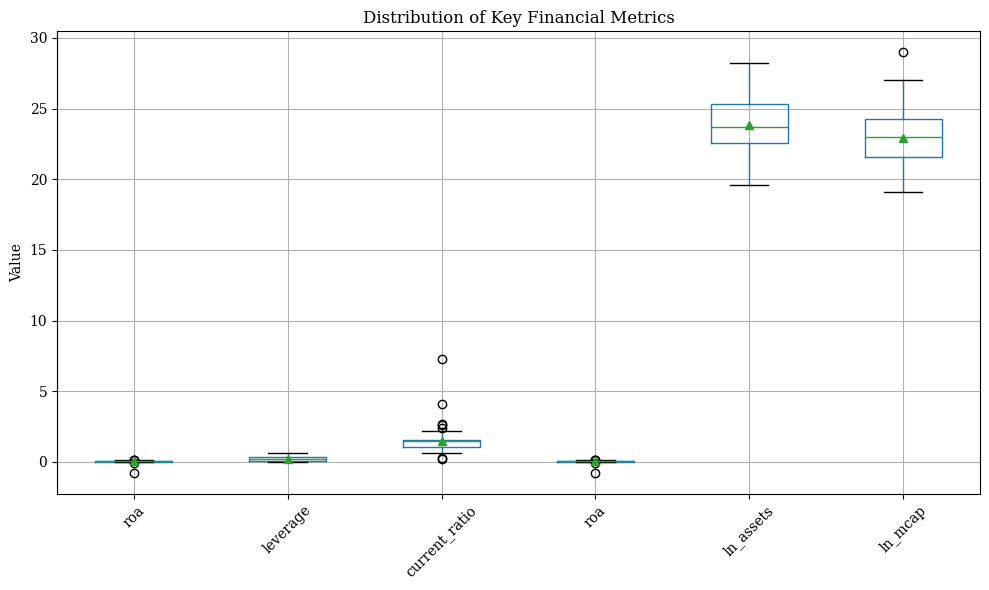

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Columns you care about
cols = [ "roa", "leverage", "current_ratio","roa","ln_assets", "ln_mcap"  ]

# 2️⃣ Quick stats table (mean & std)
stats = df[cols].agg(["mean", "std"]).T  # .T just flips rows/cols for readability
print("\nAverage & Spread (Std-Dev)\n", stats)

# 3️⃣ Boxplots
plt.figure(figsize=(10, 6))
df[cols].boxplot(showmeans=True)       # showmeans=True plots a little green triangle at the mean
plt.title("Distribution of Key Financial Metrics")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average & Spread (Std-Dev)
          mean       std
roa  0.025619  0.097209


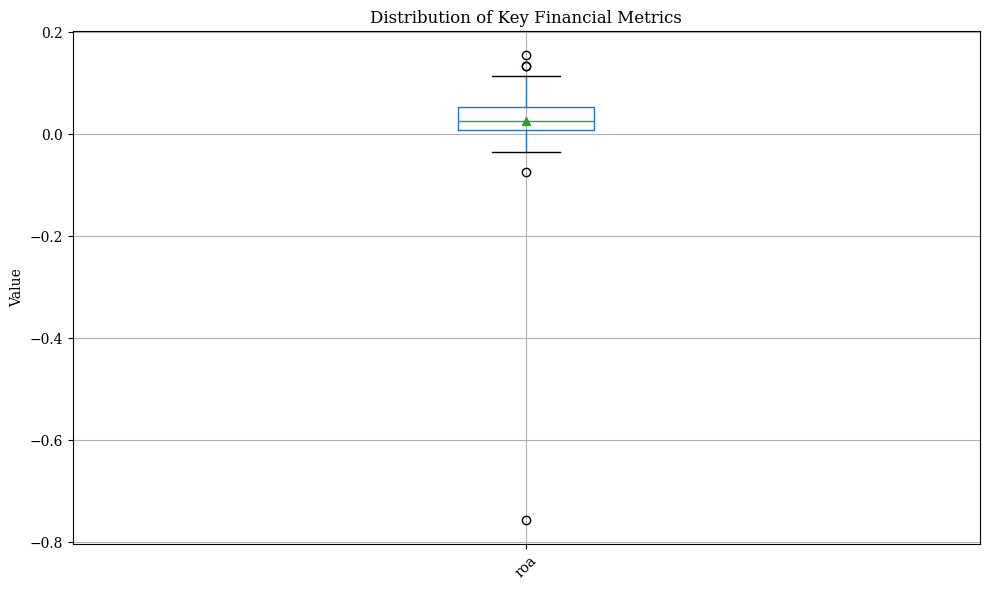

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Columns you care about
cols = [ "roa" ]

# 2️⃣ Quick stats table (mean & std)
stats = df[cols].agg(["mean", "std"]).T  # .T just flips rows/cols for readability
print("\nAverage & Spread (Std-Dev)\n", stats)

# 3️⃣ Boxplots
plt.figure(figsize=(10, 6))
df[cols].boxplot(showmeans=True)       # showmeans=True plots a little green triangle at the mean
plt.title("Distribution of Key Financial Metrics")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average & Spread (Std-Dev)
                 mean      std
ln_assets  23.827137  1.94109
ln_mcap    22.925301  1.95845


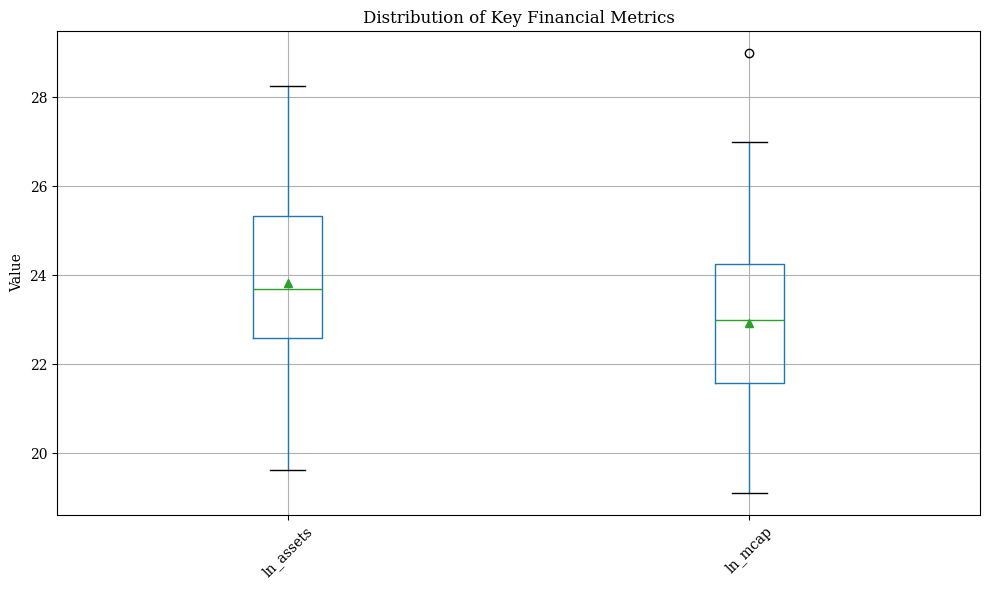

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Columns you care about
cols = [ "ln_assets", "ln_mcap"]

# 2️⃣ Quick stats table (mean & std)
stats = df[cols].agg(["mean", "std"]).T  # .T just flips rows/cols for readability
print("\nAverage & Spread (Std-Dev)\n", stats)

# 3️⃣ Boxplots
plt.figure(figsize=(10, 6))
df[cols].boxplot(showmeans=True)       # showmeans=True plots a little green triangle at the mean
plt.title("Distribution of Key Financial Metrics")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###industry

In [118]:

import pandas as pd

# 1. Load the existing fundamentals file
path = "/content/Thesis/output/esrs_2024_with_fundamentals.csv"
df = pd.read_csv(path)

# 2. Build your manual mapping as a lookup table (shortened version below)
sector_map = {
    "Utilities - Renewable": "Utilities",
    "Food Distribution": "Consumer Staples",
    "Specialty Chemicals": "Materials",
    "Chemicals": "Materials",
    "Entertainment": "Communication Services",
    "Steel": "Materials",
    "Waste Management": "Industrials",
    "Engineering & Construction": "Industrials",
    "Banks - Diversified": "Financials",
    "Electronic Components": "Information Technology",
    "Banks - Regional": "Financials",
    "Specialty Industrial Machinery": "Industrials",
    "Paper & Paper Products": "Materials",
    "Building Products & Equipment": "Industrials",
    "Software - Infrastructure": "Information Technology",
    "Semiconductor Equipment & Materials": "Information Technology",
    "Aerospace & Defense": "Industrials",
    "Asset Management": "Financials",
    "Airports & Air Services": "Industrials",
    "Auto Parts": "Consumer Discretionary",
    "Footwear & Accessories": "Consumer Discretionary",
    "Real Estate - Development": "Real Estate",
    "Specialty Business Services": "Industrials",
    "Broadcasting": "Communication Services",
    "Insurance - Diversified": "Financials",
    "Information Technology Services": "Information Technology",
    "Utilities - Diversified": "Utilities",
    "Staffing & Employment Services": "Industrials",
    "Conglomerates": "Industrials",
    "Electrical Equipment & Parts": "Industrials",
    "Beverages - Brewers": "Consumer Staples",
    "Medical Distribution": "Health Care",
    "Real Estate Services": "Real Estate",
    "Utilities - Regulated Electric": "Utilities",
    "Integrated Freight & Logistics": "Industrials",
    "Airlines": "Industrials",
    "Lodging": "Consumer Discretionary",
    "Packaged Foods": "Consumer Staples",
    "Biotechnology": "Health Care",
    "Oil & Gas Equipment & Services": "Energy",
    "Internet Retail": "Consumer Discretionary",
    "Grocery Stores": "Consumer Staples",
    "Aluminum": "Materials",
    "Security & Protection Services": "Industrials",
    "Other Industrial Metals & Mining": "Materials",
    "Building Materials": "Materials",
}

# 3. Add sector column
df["sector"] = df["industry"].map(sector_map).fillna("Unclassified")

# 4. (Optional) Check how many are still unmapped
print("Unmatched industries:", df[df["sector"] == "Unclassified"]["industry"].unique())

# 5. Save updated file
df.to_csv("/content/Thesis/output/esrs_2024_with_fundamentals.csv", index=False)

Unmatched industries: []


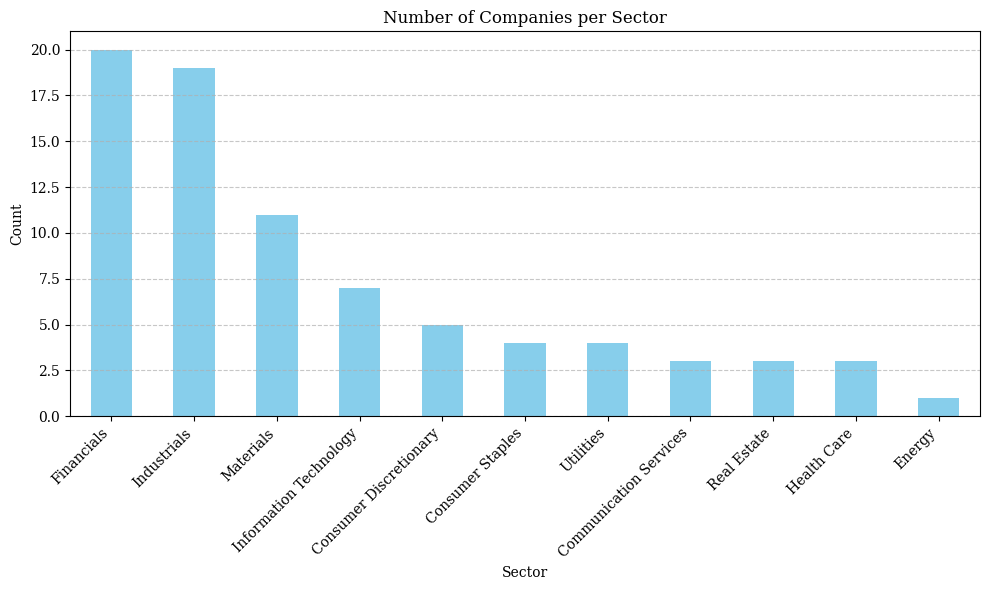

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Count companies per sector
sector_counts = df["sector"].value_counts().sort_values(ascending=False)

# 2. Plot
plt.figure(figsize=(10, 6))
sector_counts.plot(kind="bar", color="skyblue")

plt.title("Number of Companies per Sector")
plt.xlabel("Sector")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

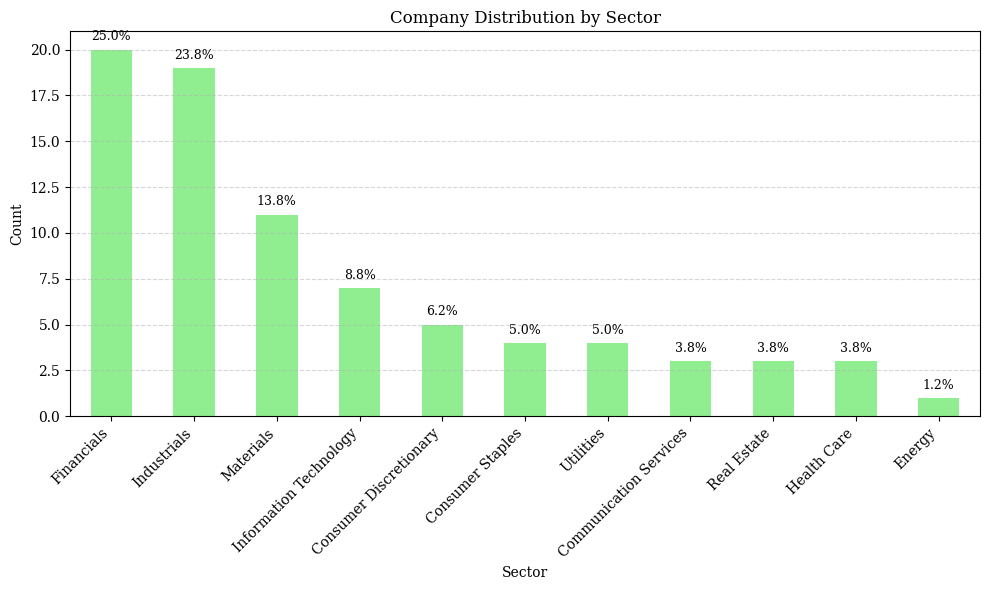

In [120]:
# With percentages on top
total = sector_counts.sum()
plt.figure(figsize=(10, 6))
bars = sector_counts.plot(kind="bar", color="lightgreen")

# Add percentage labels on top
for i, v in enumerate(sector_counts):
    percent = f"{(v / total * 100):.1f}%"
    plt.text(i, v + 0.5, percent, ha='center', fontsize=9)

plt.title("Company Distribution by Sector")
plt.xlabel("Sector")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

###country

country
Netherlands       16
France            13
Germany            8
Spain              6
Austria            5
Belgium            4
Italy              4
Finland            4
Denmark            4
Portugal           3
Norway             3
Ireland            2
Sweden             2
Luxembourg         2
United Kingdom     1
Liechtenstein      1
Poland             1
Czech Republic     1
Name: count, dtype: int64


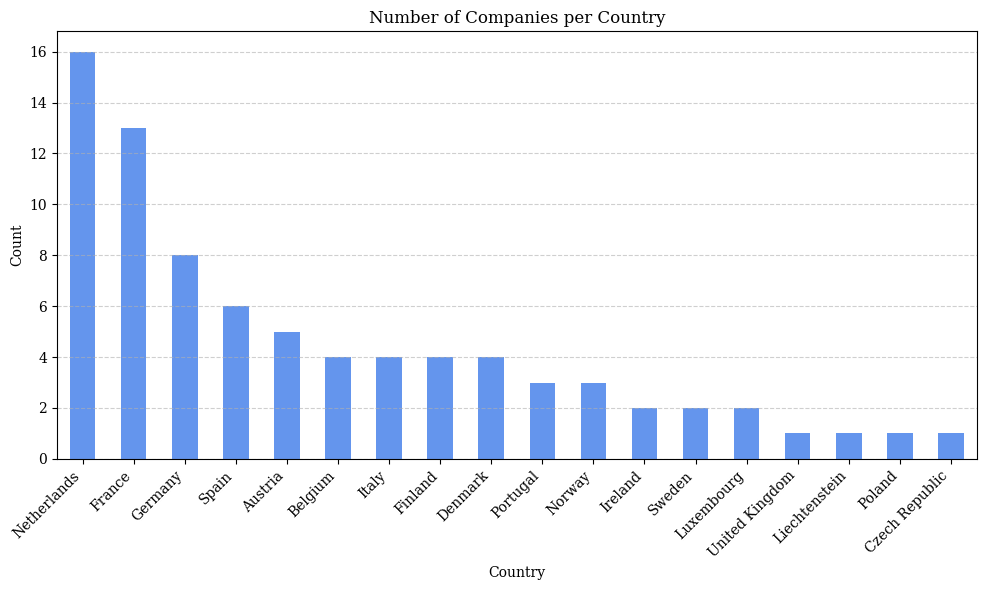

In [121]:


# 2. Count companies per country
country_counts = df["country"].value_counts().sort_values(ascending=False)

# 3. Display the table
print(country_counts)

# 4. Optional: bar chart
plt.figure(figsize=(10, 6))
country_counts.plot(kind="bar", color="cornflowerblue")

plt.title("Number of Companies per Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#fixed effects

##year and country

In [122]:
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load & prep
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)

# Count targets
df["E_count"] = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"] = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"] = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)

# Standardize selected predictors
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# Model setup
y_vars = ["ESG_count", "E_count", "S_count", "G_count"]
fin_X = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]

# --- Choose fixed effect(s) ---
formula_stub = " ~ " + " + ".join(fin_X) + " + C(country)"
# For sector instead: formula_stub = " ~ " + " + ".join(fin_X) + " + C(sector)"
# For both: formula_stub = " ~ " + " + ".join(fin_X) + " + C(country) + C(sector)"

# Model loop with evaluation
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y}{formula_stub}",
                    data=df.dropna(subset=[y] + fin_X),
                    family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull

    print(f"\n=== {y} ({'NegBin' if 'Negative' in fam.__class__.__name__ else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X])
    print("\nIRR (exp(beta)):\n", np.exp(model.params[fin_X]).round(3))
    print(f"\nEvaluation Metrics:")
    print(f"- McFadden's Pseudo R²: {pseudo_r2:.3f}")
    print(f"- AIC: {model.aic:.1f}")
    print(f"- Log-Likelihood: {model.llf:.1f}")


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.015273  0.107175  0.142503  0.886683 -0.194786  0.225332
roa_z          0.141073  0.129755  1.087229  0.276935 -0.113241  0.395388
leverage_z     0.147282  0.137790  1.068886  0.285121 -0.122782  0.417346
ln_mcap       -0.009603  0.117857 -0.081484  0.935057 -0.240599  0.221392
current_ratio -0.003970  0.149986 -0.026471  0.978881 -0.297938  0.289997

IRR (exp(beta)):
 ln_assets        1.015
roa_z            1.152
leverage_z       1.159
ln_mcap          0.990
current_ratio    0.996
dtype: float64

Evaluation Metrics:
- McFadden's Pseudo R²: 0.016
- AIC: 781.2
- Log-Likelihood: -367.6

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.136899  0.115027  1.190146  0.233989 -0.088550  0.362347
roa_z          0.428711  0.199560  2.148280  0.031692  0.037580  0.819843
leverage_z     0.343763  0.141301  2.43283

In [123]:
print(df["ESG_count"].describe())

count    80.000000
mean     38.725000
std      19.617852
min       0.000000
25%      27.000000
50%      37.500000
75%      52.250000
max      69.000000
Name: ESG_count, dtype: float64


### add industry

In [124]:
# Define "high-emissive" vs "other"
high_emit = ["Energy", "Utilities", "Materials", "Industrials"]  # adjust as needed
df["high_emit"] = df["sector"].isin(high_emit).astype(int)       # 1 = high-impact

print("\n########  STEP 1:  Country FE + High-Emit Dummy ########")
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    formula = f"{y} ~ {' + '.join(fin_X)} + C(country) + high_emit"
    model   = smf.glm(formula, data=df.dropna(subset=[y] + fin_X),
                      family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull
    print(f"\n=== {y} ({'NegBin' if var/mu>2 else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X + ['high_emit']])
    print("IRR:\n", np.exp(model.params[fin_X + ['high_emit']]).round(3))
    print(f"McFadden R²={pseudo_r2:.3f}  AIC={model.aic:.1f}")



########  STEP 1:  Country FE + High-Emit Dummy ########

=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.023618  0.108565  0.217549  0.827780 -0.189166  0.236403
roa_z          0.130023  0.131011  0.992459  0.320974 -0.126754  0.386800
leverage_z     0.083874  0.146531  0.572396  0.567054 -0.203321  0.371069
ln_mcap       -0.023326  0.118767 -0.196401  0.844296 -0.256105  0.209453
current_ratio  0.008109  0.150525  0.053870  0.957039 -0.286914  0.303132
high_emit      0.318880  0.277714  1.148230  0.250873 -0.225430  0.863189
IRR:
 ln_assets        1.024
roa_z            1.139
leverage_z       1.087
ln_mcap          0.977
current_ratio    1.008
high_emit        1.376
dtype: float64
McFadden R²=0.018  AIC=782.0

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.170374  0.120446  1.414525  0.157208 -0.065696  0.406445
roa_z          0.457430  0.230830 

In [125]:

import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")

# Identify ESRS columns
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)

# Create depth counts
df["E_count"]   = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"]   = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"]   = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)

# Standardise ROA & leverage (literature: makes coefficients comparable)
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# Core predictors
fin_X = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
y_vars = ["ESG_count", "E_count", "S_count", "G_count"]


high_emit = ["Energy", "Utilities", "Materials", "Industrials"]  # adjust as needed
df["high_emit"] = df["sector"].isin(high_emit).astype(int)       # 1 = high-impact

print("STEP 1")
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    formula = f"{y} ~ {' + '.join(fin_X)} + C(country) + high_emit"
    model   = smf.glm(formula, data=df.dropna(subset=[y] + fin_X),
                      family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull
    print(f"\n=== {y} ({'NegBin' if var/mu>2 else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X + ['high_emit']])
    print("IRR:\n", np.exp(model.params[fin_X + ['high_emit']]).round(3))
    print(f"McFadden R²={pseudo_r2:.3f}  AIC={model.aic:.1f}")


print("STEP 2:")
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    formula = (
        f"{y} ~ {' + '.join(fin_X)} + C(country) "
        "+ high_emit + roa_z:high_emit"
    )
    model = smf.glm(formula, data=df.dropna(subset=[y] + fin_X),
                    family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull
    # Display main vars, dummy, and interaction
    keep = fin_X + ['high_emit', 'roa_z:high_emit']
    print(f"\n=== {y} with Interaction ({'NegBin' if var/mu>2 else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[keep])
    print("IRR:\n", np.exp(model.params[keep]).round(3))
    print(f"McFadden R²={pseudo_r2:.3f}  AIC={model.aic:.1f}")

STEP 1

=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.023618  0.108565  0.217549  0.827780 -0.189166  0.236403
roa_z          0.130023  0.131011  0.992459  0.320974 -0.126754  0.386800
leverage_z     0.083874  0.146531  0.572396  0.567054 -0.203321  0.371069
ln_mcap       -0.023326  0.118767 -0.196401  0.844296 -0.256105  0.209453
current_ratio  0.008109  0.150525  0.053870  0.957039 -0.286914  0.303132
high_emit      0.318880  0.277714  1.148230  0.250873 -0.225430  0.863189
IRR:
 ln_assets        1.024
roa_z            1.139
leverage_z       1.087
ln_mcap          0.977
current_ratio    1.008
high_emit        1.376
dtype: float64
McFadden R²=0.018  AIC=782.0

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.170374  0.120446  1.414525  0.157208 -0.065696  0.406445
roa_z          0.457430  0.230830  1.981670  0.047516  0.005010  0.909849
leverage_z 

##year and industry

In [126]:
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load & prep
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)

# Count targets
df["E_count"] = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"] = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"] = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)

# Standardize selected predictors
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# Model setup
y_vars = ["ESG_count", "E_count", "S_count", "G_count"]
fin_X = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]


formula_stub = " ~ " + " + ".join(fin_X) + " + C(sector)"


# Model loop with evaluation
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y}{formula_stub}",
                    data=df.dropna(subset=[y] + fin_X),
                    family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull

    print(f"\n=== {y} ({'NegBin' if 'Negative' in fam.__class__.__name__ else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X])
    print("\nIRR (exp(beta)):\n", np.exp(model.params[fin_X]).round(3))
    print(f"\nEvaluation Metrics:")
    print(f"- McFadden's Pseudo R²: {pseudo_r2:.3f}")
    print(f"- AIC: {model.aic:.1f}")
    print(f"- Log-Likelihood: {model.llf:.1f}")


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.098677  0.152052  0.648969  0.516358 -0.199340  0.396694
roa_z          0.128827  0.150641  0.855191  0.392445 -0.166424  0.424077
leverage_z    -0.031890  0.186364 -0.171116  0.864133 -0.397157  0.333377
ln_mcap       -0.103528  0.128090 -0.808247  0.418948 -0.354579  0.147523
current_ratio  0.016588  0.168622  0.098374  0.921635 -0.313906  0.347082

IRR (exp(beta)):
 ln_assets        1.104
roa_z            1.137
leverage_z       0.969
ln_mcap          0.902
current_ratio    1.017
dtype: float64

Evaluation Metrics:
- McFadden's Pseudo R²: 0.009
- AIC: 772.0
- Log-Likelihood: -370.0

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.208204  0.162720  1.279523  0.200713 -0.110721  0.527130
roa_z          0.508065  0.298770  1.700521  0.089033 -0.077514  1.093645
leverage_z     0.021093  0.190773  0.11056

In [127]:

import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

# 1 ▸ Define Hofstede-“feminine” countries (MAS < 50, plus LU = 50)
feminine_ctys = [
    "Sweden", "Norway", "Denmark", "Finland",
    "Netherlands", "Portugal", "France", "Spain",
    "Luxembourg"          # borderline (MAS = 50)
]
df["feminine"] = df["country"].isin(feminine_ctys).astype(int)

# 2 ▸ Core predictors
fin_X = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]

# 3 ▸ Model A – Financials + feminine dummy  (no sector FE)
formula_A = "ESG_count ~ " + " + ".join(fin_X) + " + feminine"
mu, var = df["ESG_count"].mean(), df["ESG_count"].var()
fam = sm.families.NegativeBinomial() if var / mu > 2 else sm.families.Poisson()
mA = smf.glm(formula_A, data=df.dropna(subset=["ESG_count"] + fin_X), family=fam).fit()

# 4 ▸ Model B – Add sector fixed effects
formula_B = formula_A + " + C(sector)"
mB = smf.glm(formula_B, data=df.dropna(subset=["ESG_count"] + fin_X), family=fam).fit()

# 5 ▸ Display results
for name, mdl in [("Model A  (no sector FE)", mA), ("Model B  (+ sector FE)", mB)]:
    pseudo_r2 = 1 - mdl.llf / mdl.llnull
    keep = fin_X + ["feminine"]
    print(f"\n==== {name} ====")
    print(mdl.summary2().tables[1].loc[keep])
    print("IRR:\n", np.exp(mdl.params[keep]).round(3))
    print(f"McFadden R² = {pseudo_r2:.3f}   AIC = {mdl.aic:.1f}")


==== Model A  (no sector FE) ====
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.034350  0.096182  0.357136  0.720990 -0.154163  0.222864
roa_z          0.160874  0.125303  1.283877  0.199185 -0.084716  0.406464
leverage_z     0.122709  0.121626  1.008904  0.313021 -0.115674  0.361092
ln_mcap       -0.039338  0.094424 -0.416613  0.676961 -0.224406  0.145729
current_ratio -0.038103  0.142836 -0.266762  0.789653 -0.318056  0.241850
feminine      -0.128424  0.243243 -0.527968  0.597522 -0.605172  0.348323
IRR:
 ln_assets        1.035
roa_z            1.175
leverage_z       1.131
ln_mcap          0.961
current_ratio    0.963
feminine         0.879
dtype: float64
McFadden R² = 0.003   AIC = 758.7

==== Model B  (+ sector FE) ====
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.099051  0.152671  0.648787  0.516476 -0.200178  0.398279
roa_z          0.131143  0.150939  0.868844  0.384932 -0.164693  0.42697

In [128]:

import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np


feminine_ctys = [
    "Sweden", "Norway", "Denmark", "Finland",
    "Netherlands", "Portugal", "France", "Spain",
    "Luxembourg"
]
df["feminine"] = df["country"].isin(feminine_ctys).astype(int)

# 2
fin_X  = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
y_vars = ["E_count", "S_count", "G_count"]

# 3
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    formula = f"{y} ~ {' + '.join(fin_X)} + feminine + C(sector)"
    mdl     = smf.glm(formula, data=df.dropna(subset=[y] + fin_X), family=fam).fit()

    pseudo_r2 = 1 - mdl.llf / mdl.llnull
    keep      = fin_X + ["feminine"]

    print(f"\n==== {y}  ({'NegBin' if var/mu>2 else 'Poisson'}) ====")
    print(mdl.summary2().tables[1].loc[keep])            # coefficients
    print("IRR (exp(beta)):\n", np.exp(mdl.params[keep]).round(3))
    print(f"McFadden R² = {pseudo_r2:.3f}   AIC = {mdl.aic:.1f}")


==== E_count  (NegBin) ====
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.207451  0.163818  1.266350  0.205388 -0.113626  0.528527
roa_z          0.518006  0.304173  1.702998  0.088568 -0.078162  1.114173
leverage_z     0.035919  0.194842  0.184351  0.853738 -0.345964  0.417803
ln_mcap       -0.158430  0.139682 -1.134224  0.256701 -0.432201  0.115341
current_ratio  0.133714  0.174670  0.765519  0.443962 -0.208634  0.476062
feminine      -0.106921  0.276009 -0.387384  0.698472 -0.647888  0.434045
IRR (exp(beta)):
 ln_assets        1.231
roa_z            1.679
leverage_z       1.037
ln_mcap          0.853
current_ratio    1.143
feminine         0.899
dtype: float64
McFadden R² = 0.033   AIC = 614.4

==== S_count  (NegBin) ====
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.076084  0.154556  0.492274  0.622525 -0.226840  0.379007
roa_z          0.113494  0.153033  0.741632  0.458310 -0.186445  0.4134

In [129]:

count_tbl = (
    df["feminine"]
      .value_counts()
      .rename(index={0: "Non-feminine", 1: "Feminine"})
      .to_frame("N_firms")
)
count_tbl["Share_%"] = 100 * count_tbl["N_firms"] / len(df)
print(count_tbl)


country_tbl = (
    df.groupby(["country", "feminine"])
      .size()
      .unstack(fill_value=0)
      .rename(columns={0: "Non-fem", 1: "Fem"})
      .sort_values("Fem", ascending=False)
)
print("\nFirms per country (Fem vs Non-Fem):")
print(country_tbl)

              N_firms  Share_%
feminine                      
Feminine           53    66.25
Non-feminine       27    33.75

Firms per country (Fem vs Non-Fem):
feminine        Non-fem  Fem
country                     
Netherlands           0   16
France                0   13
Spain                 0    6
Denmark               0    4
Finland               0    4
Portugal              0    3
Norway                0    3
Sweden                0    2
Luxembourg            0    2
Austria               5    0
Belgium               4    0
Liechtenstein         1    0
Ireland               2    0
Germany               8    0
Czech Republic        1    0
Italy                 4    0
Poland                1    0
United Kingdom        1    0


##both fixed

In [130]:
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load & prep
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)

# Count targets
df["E_count"] = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"] = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"] = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)


for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)


y_vars = ["ESG_count", "E_count", "S_count", "G_count"]
fin_X = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]


formula_stub = " ~ " + " + ".join(fin_X) + " + C(country) + C(sector)"


# Model loop
for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y}{formula_stub}",
                    data=df.dropna(subset=[y] + fin_X),
                    family=fam).fit()

    pseudo_r2 = 1 - model.llf / model.llnull

    print(f"\n=== {y} ({'NegBin' if 'Negative' in fam.__class__.__name__ else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X])
    print("\nIRR (exp(beta)):\n", np.exp(model.params[fin_X]).round(3))
    print(f"\nEvaluation Metrics:")
    print(f"- McFadden's Pseudo R²: {pseudo_r2:.3f}")
    print(f"- AIC: {model.aic:.1f}")
    print(f"- Log-Likelihood: {model.llf:.1f}")


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.023313  0.180574  0.129105  0.897275 -0.330605  0.377231
roa_z          0.092336  0.155157  0.595113  0.551768 -0.211766  0.396438
leverage_z    -0.055369  0.221512 -0.249958  0.802620 -0.489524  0.378787
ln_mcap       -0.000694  0.163891 -0.004237  0.996620 -0.321914  0.320525
current_ratio  0.053254  0.187603  0.283865  0.776514 -0.314441  0.420949

IRR (exp(beta)):
 ln_assets        1.024
roa_z            1.097
leverage_z       0.946
ln_mcap          0.999
current_ratio    1.055
dtype: float64

Evaluation Metrics:
- McFadden's Pseudo R²: 0.021
- AIC: 797.1
- Log-Likelihood: -365.5

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.251114  0.201591  1.245660  0.212889 -0.143998  0.646226
roa_z          0.492575  0.331997  1.483672  0.137896 -0.158128  1.143278
leverage_z     0.054059  0.227174  0.23796

## count no fixed effect


In [131]:
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 0
df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")

# 1
code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)

# 2
df["E_count"]   = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"]   = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"]   = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)

# 3
for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# 4
y_vars = ["ESG_count", "E_count", "S_count", "G_count"]
fin_X  = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
formula_stub = " ~ " + " + ".join(fin_X)

for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y}{formula_stub}",
                    data=df.dropna(subset=[y] + fin_X),
                    family=fam).fit()

    print(f"\n=== {y} ({'NegBin' if 'Negative' in fam.__class__.__name__ else 'Poisson'}) ===")
    print(model.summary2().tables[1].loc[fin_X])     # coeffs for the five X-vars
    print("\nIRR (exp(beta)):\n", np.exp(model.params[fin_X]).round(3))


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.043485  0.095855  0.453658  0.650075 -0.144387  0.231358
roa_z          0.163623  0.125197  1.306925  0.191238 -0.081758  0.409004
leverage_z     0.116403  0.121183  0.960556  0.336776 -0.121111  0.353917
ln_mcap       -0.050090  0.093546 -0.535458  0.592333 -0.233436  0.133256
current_ratio -0.035641  0.142722 -0.249723  0.802801 -0.315371  0.244089

IRR (exp(beta)):
 ln_assets        1.044
roa_z            1.178
leverage_z       1.123
ln_mcap          0.951
current_ratio    0.965
dtype: float64

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
ln_assets      0.114691  0.103152  1.111871  0.266194 -0.087482  0.316865
roa_z          0.465369  0.202386  2.299417  0.021481  0.068700  0.862037
leverage_z     0.246198  0.123930  1.986582  0.046969  0.003299  0.489097
ln_mcap       -0.079128  0.100647 -0.786191  0.431756 -0.

###E

In [132]:
import pandas as pd, numpy as np, statsmodels.formula.api as smf
import re

df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")


code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
assert code_cols, "No ESRS code columns matched – check the regex!"


df[code_cols] = df[code_cols].apply(
    lambda s: pd.to_numeric(s, errors="coerce")
).fillna(0).astype(int)



e_cols = [c for c in code_cols if c.startswith("E")]
df["E_count"] = df[e_cols].sum(axis=1)

print(df["E_count"].describe())
print(df["E_count"].value_counts().sort_index().head())

print(df[["company", "E1-1", "E1-2", "E_count"]].head())



count    80.000000
mean     15.187500
std      10.133406
min       0.000000
25%       7.000000
50%      13.500000
75%      25.000000
max      31.000000
Name: E_count, dtype: float64
E_count
0    7
1    2
2    1
4    1
5    1
Name: count, dtype: int64
                                             company  E1-1  E1-2  E_count
0  verbund-integrated-annual-report-2024-englisch...     1     1       28
1                                amsterdam commodity     1     1       13
2                                             arkema     1     1       25
3                                               basf     1     1       27
4                        20250407_viv_vivendi_urd_en     0     0        0


In [133]:
fin_X   = ["ln_assets", "roa", "leverage", "ln_mcap", "current_ratio"]
formula = "E_count ~ " + " + ".join(fin_X)

# Poisson
pois = smf.glm(formula,
               data=df.dropna(subset=["E_count"] + fin_X),
               family=sm.families.Poisson()).fit()      # ← use sm.families.*


mu, var = df["E_count"].mean(), df["E_count"].var()
print(f"\nvar/mean = {var/mu:.2f}")

if var / mu > 2:
    nb = smf.glm(formula,
                 data=df,
                 family=sm.families.NegativeBinomial()).fit()
    print("\nNegative-Binomial (to handle over-dispersion):")
    print(nb.summary().tables[1])


var/mean = 6.76

Negative-Binomial (to handle over-dispersion):
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2427      1.657      0.750      0.453      -2.005       4.490
ln_assets         0.1147      0.103      1.112      0.266      -0.087       0.317
roa               4.8175      2.095      2.299      0.021       0.711       8.924
leverage          1.7031      0.857      1.987      0.047       0.023       3.383
ln_mcap          -0.0791      0.101     -0.786      0.432      -0.276       0.118
current_ratio     0.0073      0.145      0.050      0.960      -0.278       0.292


###G


count    80.000000
mean      3.700000
std       2.224148
min       0.000000
25%       2.000000
50%       4.000000
75%       6.000000
max       6.000000
Name: G_count, dtype: float64


<Axes: xlabel='G_count'>

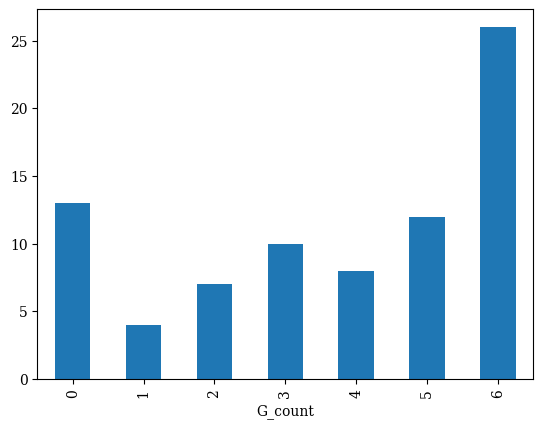

In [134]:

e_cols = [c for c in df.columns if c.startswith("G")]
df["G_count"] = df[e_cols].fillna(0).astype(int).sum(axis=1)

print(df["G_count"].describe())
df["G_count"].value_counts().sort_index().plot.bar()

In [135]:
X_vars = ["ln_assets", "roa", "leverage", "current_ratio", "ln_mcap"]
model_df = df[["G_count"] + X_vars].dropna()

In [136]:
print("Mean:", model_df["G_count"].mean(),
      "Var:",  model_df["G_count"].var())

Mean: 3.7 Var: 4.946835443037974


In [137]:

model_df = df.dropna(subset=X_vars + ["country","G_count"]).copy()
rare = model_df['country'].value_counts().loc[lambda s: s < 5].index
model_df.loc[model_df['country'].isin(rare), 'country'] = 'Other'


formula = "G_count ~ " + " + ".join(X_vars) + " + C(country)"
y_g, X_g = patsy.dmatrices(formula, model_df, return_type="dataframe")


pois_cty = sm.GLM(y_g, X_g, family=sm.families.Poisson()).fit()


nb_cty = sm.GLM(y_g, X_g, family=sm.families.NegativeBinomial()) \
            .fit(start_params=pois_cty.params, maxiter=50, disp=0)

print(nb_cty.summary())
print("\nIRR:\n", np.exp(nb_cty.params).round(3))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                G_count   No. Observations:                   80
Model:                            GLM   Df Residuals:                       69
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -193.86
Date:                Wed, 25 Jun 2025   Deviance:                       50.710
Time:                        21:28:26   Pearson chi2:                     22.1
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01879
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

###added countires to count

In [138]:
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf
import statsmodels.api as sm


df = pd.read_csv("Thesis/output/esrs_2024_with_fundamentals.csv")


code_cols = [c for c in df.columns if re.fullmatch(r"[ESG]\d-\d+", c)]
df[code_cols] = df[code_cols].fillna(0).astype(int)


df["E_count"]   = df[[c for c in code_cols if c.startswith("E")]].sum(axis=1)
df["S_count"]   = df[[c for c in code_cols if c.startswith("S")]].sum(axis=1)
df["G_count"]   = df[[c for c in code_cols if c.startswith("G")]].sum(axis=1)
df["ESG_count"] = df[code_cols].sum(axis=1)

In [139]:



df["DE_dummy"] = (df["country"] == "Germany").astype(int)
df["NL_dummy"] = (df["country"] == "Netherlands").astype(int)


for col in ["roa", "leverage"]:
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)


fin_X  = ["ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
cty_X  = ["DE_dummy", "NL_dummy"]               # <- just added
formula_stub = " + ".join(cty_X + fin_X)        # order doesn’t matter


y_vars = ["ESG_count", "E_count", "S_count", "G_count"]

for y in y_vars:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var/mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y} ~ {formula_stub}",
                    data=df.dropna(subset=[y] + fin_X + cty_X),
                    family=fam).fit()

    print(f"\n=== {y} ({'NegBin' if fam.__class__.__name__=='NegativeBinomial' else 'Poisson'}) ===")

    # ── use summary2 → DataFrame ─────────────────────────────────
    coef_tbl = model.summary2().tables[1]       # DataFrame, .loc works
    want = ["DE_dummy", "NL_dummy",
            "ln_assets", "roa_z", "leverage_z", "ln_mcap", "current_ratio"]
    print(coef_tbl.loc[want])

    # IRR
    irr = np.exp(model.params[want]).round(3)
    print("\nIRR (exp(beta)):\n", irr)


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
DE_dummy       0.008839  0.390628  0.022628  0.981947 -0.756779  0.774457
NL_dummy      -0.202617  0.302561 -0.669671  0.503068 -0.795626  0.390393
ln_assets      0.024524  0.098241  0.249628  0.802875 -0.168025  0.217072
roa_z          0.163050  0.125143  1.302915  0.192604 -0.082225  0.408325
leverage_z     0.097357  0.122066  0.797572  0.425119 -0.141889  0.336602
ln_mcap       -0.037299  0.094829 -0.393334  0.694073 -0.223161  0.148562
current_ratio -0.026236  0.144736 -0.181267  0.856158 -0.309914  0.257442

IRR (exp(beta)):
 DE_dummy         1.009
NL_dummy         0.817
ln_assets        1.025
roa_z            1.177
leverage_z       1.102
ln_mcap          0.963
current_ratio    0.974
dtype: float64

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
DE_dummy       0.120111  0.397823  0.301921  0.762712 -0.659607  0.899829
NL_dummy   

In [140]:


df["Core_dummy"] = df["country"].isin(["Germany", "Netherlands"]).astype(int)

# predictor stub
formula_stub = "Core_dummy + " + " + ".join(fin_X)


for y in ["ESG_count", "E_count", "S_count", "G_count"]:
    mu, var = df[y].mean(), df[y].var()
    fam = sm.families.NegativeBinomial() if var / mu > 2 else sm.families.Poisson()

    model = smf.glm(f"{y} ~ {formula_stub}",
                    data=df.dropna(subset=[y] + fin_X + ["Core_dummy"]),
                    family=fam).fit()

    print(f"\n=== {y} ({'NegBin' if 'Negative' in fam.__class__.__name__ else 'Poisson'}) ===")
    coef_tbl = model.summary2().tables[1]
    print(coef_tbl.loc[["Core_dummy"] + fin_X])          # tidy view
    print("\nIRR (exp(beta)):\n", np.exp(model.params[["Core_dummy"] + fin_X]).round(3))


=== ESG_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
Core_dummy    -0.120465  0.262267 -0.459322  0.646003 -0.634499  0.393569
ln_assets      0.030418  0.098142  0.309935  0.756611 -0.161938  0.222773
roa_z          0.162021  0.125105  1.295084  0.195291 -0.083180  0.407222
leverage_z     0.103003  0.121756  0.845983  0.397562 -0.135634  0.341640
ln_mcap       -0.039333  0.094793 -0.414933  0.678191 -0.225123  0.146458
current_ratio -0.025793  0.144633 -0.178335  0.858460 -0.309269  0.257683

IRR (exp(beta)):
 Core_dummy       0.887
ln_assets        1.031
roa_z            1.176
leverage_z       1.108
ln_mcap          0.961
current_ratio    0.975
dtype: float64

=== E_count (NegBin) ===
                  Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
Core_dummy    -0.003311  0.267866 -0.012362  0.990137 -0.528318  0.521695
ln_assets      0.114344  0.105590  1.082910  0.278848 -0.092608  0.321296
roa_z          0.465079  0.202301 